# RDKit: making new molecules using reaction SMARTS

This notebook explores using `RDKit` to define chemical reactions and to use these reactions to create new molecules from existing reactants. It uses RDKit's SMARTS matches.  This notebook isn't a replacment for the [rdkit documentation](http://www.rdkit.org/docs/), but is intended to complement it.

@TAGS: #basics #reactions

In [1]:
# from __future__ import print_function
# import rdkit components
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors

# use IPythonConsole for pretty drawings
from rdkit.Chem.Draw import IPythonConsole

## The next line is commented out 
### because GitHub does not render svg's embedded in notebooks
# IPythonConsole.ipython_useSVG=True
IPythonConsole.ipython_useSVG=False

# for flattening tuples and lists
from itertools import chain

# An example unimolecular reaction: the oxidation of alcohols to ketones

It's easy to get a feel for how the system works with some simple examples.  Let's take the oxidation of alcohols to ketones/aldehydes.  In real life, these reactions are not really unimolecular.  The electrons and hydrogen atoms that leave during the oxidation have to go somewhere.  But in these examples we aren't tracking the fate of those atoms; we're only tracking the transformations that happen to a single rdkit molecule.  That's what we mean by unimolecular.

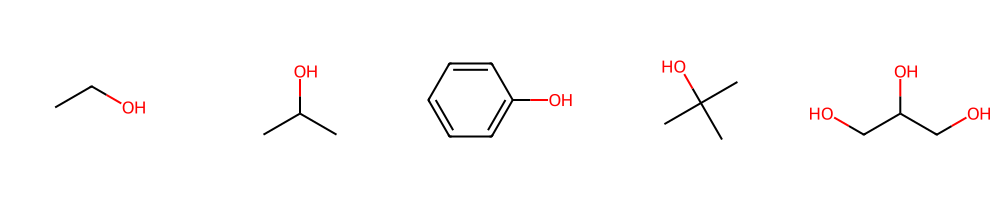

In [2]:
ethanol = Chem.MolFromSmiles('CCO')
isopropanol = Chem.MolFromSmiles('CC(C)O')
phenol = Chem.MolFromSmiles('c1cccc(O)c1')
t_butanol = Chem.MolFromSmiles('C(C)(C)(C)O')
glycerol = Chem.MolFromSmiles('OCC(O)CO')

alcohols = [ethanol, isopropanol, phenol, t_butanol, glycerol]

Draw.MolsToGridImage(alcohols, molsPerRow=5)

### A very general reaction definition

There are a few ways we could imagine defining the reaction.  We'll take the most general way imaginable first.

In [3]:
rxn_1 = AllChem.ReactionFromSmarts('[#6:1][O:2]>>[#6:1]=[O:2]')

This definition says:

  1. Take _any_ carbon atom, which we'll label as atom #1, whether aliphatic or aromatic, that ...
  2. ... is bound via a single bond to an aliphatic oxygen atom (capital O), that we label as atom #2, and
  3. transform the linkage between these atoms to be a double bond.
  
This is an OK definition, but it is going to run into problems.  Phenol and $t$-butanol don't oxidize, because if they did it would either disrupt aromaticity or result in a pentavalent carbon.  rdkit has ways of letting us know about this, as we shall see.

First, we have to run the reaction.  Let's show it working on isopropanol.

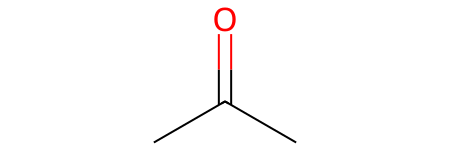

In [5]:
rxn_1.RunReactants((isopropanol, ))[0][0]

A couple of things to note about the input and output to the `RunReactants()` method:
  1.  The input is a Python _tuple_.  Note the extra parentheses and the trailing comma in the input above.  For the single molecule we have here, it seems confusing, but this format makes it easy to supply multiple molecules into a single reaction.
  2.  The output is a tuple of tuples.  The _inner_ tuples are there because even reactions that take only a single input molecule can result in multiple output molecules (e.g. hydrolysis).  The _outer_ tuples are there because rdkit applies your reaction incidence of the appropriate motifs in the input molecule, even if it occurs more than once.  
  
The upshot of all this is that it can take a bit of indexing to get your molecule out.  Note the trailing `[0][0]` below.

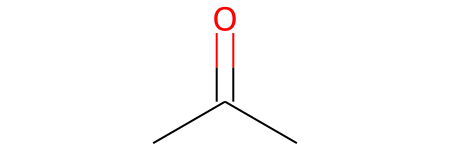

In [5]:
rxn_1.RunReactants((isopropanol, ))[0][0]

Behold!  We have produced acetone.  Now let's try one of the problematic examples.

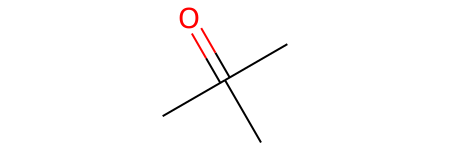

In [6]:
rxn_1.RunReactants((t_butanol, ))[0][0]

Uh-oh!  RDKit gave us a pentavalent carbon.  That can't be right.  

The reason this happens is that by default, the products of `RunReactants` are not sanitized, i.e., rdkit doesn't check to see if they make sense.  We can do that check using `Chem.SanitizeMol()`, and the results match up with chemical common sense.

In [14]:
# acetone can be sanitized, no problems here
acetone = rxn_1.RunReactants((isopropanol, ))[0][0]
Chem.SanitizeMol(acetone)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

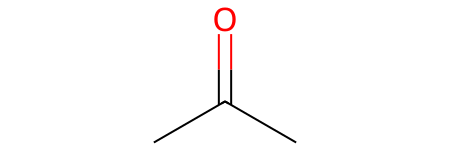

In [15]:
acetone

Sanitization FAILED!


[22:06:42] Explicit valence for atom # 0 C, 5, is greater than permitted


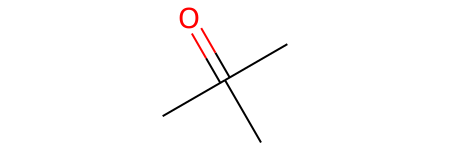

In [11]:
#doctest: IGNORE
# "t-butyl ketone" cannot be sanitized, this is going to give an error
crazy_molecule = rxn_1.RunReactants((t_butanol, ))[0][0]
try:
    Chem.SanitizeMol(crazy_molecule)
except ValueError:
    print('Sanitization FAILED!')
    
# Drawing the moecule will create rdkit warning messages that start with `RDKit ERROR:`
crazy_molecule

The warning message is a clue that something is wonky with the "ketone" that we created with the reaction. Phenol presents another problematic case for our reaction.  

In [16]:
#doctest: IGNORE
# "phenyl ketone" cannot be kekulized
crazy_molecule = rxn_1.RunReactants((phenol, ))[0][0]
try:
    Chem.SanitizeMol(crazy_molecule)
except ValueError:
    print("Sanitization failed.")
    
# Drawing the molecule will create rdkit warning messages that start with `RDKit ERROR:`,
# so we skip it here
crazy_molecule = rxn_1.RunReactants((phenol, ))[0][0]
# crazy_molecule

Sanitization failed.


[22:07:34] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6


The lesson here is that reactions can create crazy molecules.  This is usually a sign that your reaction is defined too generally.  There are ways to fix that, but for now, let's see what happens with glycerol.

In [17]:
rxn_1.RunReactants((glycerol, ))

((<rdkit.Chem.rdchem.Mol at 0x1857f6d4890>,),
 (<rdkit.Chem.rdchem.Mol at 0x1857f6d5230>,),
 (<rdkit.Chem.rdchem.Mol at 0x1857f6d52a0>,))

Now the ouput is a length-3 tuple of length-1 tuples.  This means that rdkit found three places in the reactant to apply the reaction rule, and each reaction created a single molecule as the product.  This makes sense because glycerol does have three hydroxyl atoms that can be oxidized.  A Pythonic way to look at all these products at once is to unpack the tuples with the `chain.from_iterable()` method from `itertools`.

In [18]:
glycerol_products = list(chain.from_iterable(rxn_1.RunReactants((glycerol, ))))
[Chem.SanitizeMol(mol) for mol in glycerol_products]

[rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE]

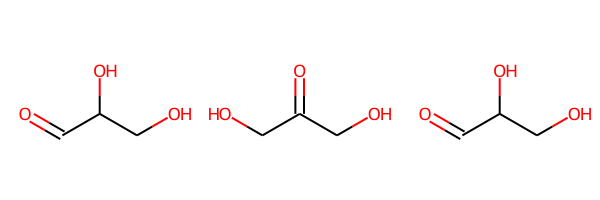

In [13]:
Draw.MolsToGridImage(glycerol_products)

rdkit does not know about the symmetry of the glycerol molecule, i.e. that oxidizing carbon 1 gives the same molecule as oxidizing carbon 3. So glyceraldehyde appears twice while dihydroxyacetone appears only once.  

It can be tricky to reduce sets of molecules to "unique" sets of molecules in rdkit.  rdkit molecules are really pointers to locations in memory, so equating two molecules in Python will always give `False`.  Doing the comparison in a simple case like this can be done by converting to SMILES.   

Once the molecules have been converted to SMILES string representations, we can use Python's `set` object type to keep only the unique objects, and then covert back to rdkit molecules.

In [14]:
glycerol_unique_products = []
glycerol_product_smiles = set()
for mol in glycerol_products:
    smi = Chem.MolToSmiles(mol)
    if smi not in glycerol_product_smiles:
        glycerol_product_smiles.add(smi)
        glycerol_unique_products.append(mol)
len(glycerol_unique_products)

2

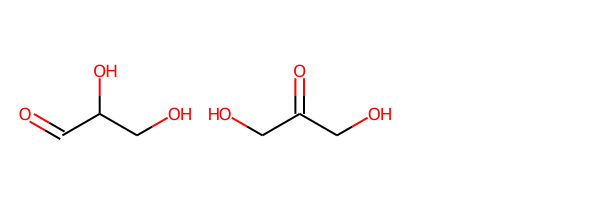

In [15]:
Draw.MolsToGridImage(glycerol_unique_products)

Now we have only the two unique possible products.  It's worth noting that converting molecules to SMILES and then back into rdkit Molecules results in kekulization and sanitization, because unlike molecules created by `RunReactants()`, molecules created by `MolFromSmiles()` are kekulized and sanitized by default.

### A better, more specific reaction definition

We can fix most of the problems we've experienced with a better-defined SMARTS reaction.  Here's one that will only work on aliphatic primary or secondary alcohols.

In [16]:
rxn_2 = AllChem.ReactionFromSmarts('[CH:1][O:2]>>[C:1]=[O:2]')

In this version of the reaction, we specify that the alcohol in question must be _aliphatic_ (we've used a capital `C` in the reactant definition above) and additionally that this carbon atom must be bound to at least one hydrogen (the `h`) above.

We now apply the reaction to every molecule in our alcohol set and look at all the products.

In [17]:
all_products_tuples = tuple(rxn_2.RunReactants((mol, )) for mol in alcohols)
all_products = list(chain.from_iterable(chain.from_iterable(all_products_tuples)))

all_products_smiles = set()
all_products_unique = []
for mol in all_products:
    smi = Chem.MolToSmiles(mol)
    if smi not in all_products_smiles:
        all_products_smiles.add(smi)
        all_products_unique.append(mol)
len(all_products_unique)


2

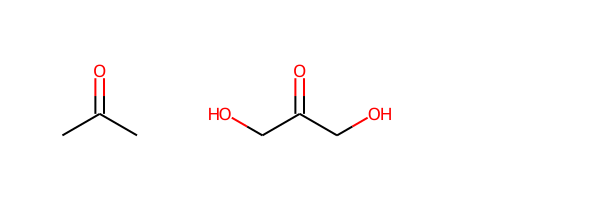

In [18]:
Draw.MolsToGridImage(all_products_unique)

The new reaction definition automatically excludes tertiary alcohols and aryl alchols.  

## More complex reactions

The same basic ideas can be used to create reactions that involve more than one reactant molecule, or that create more than one product.  The only new idea is that a dot `.` is used in SMARTS reactions definitions to separate molecules in the input or output. 

Let's continue with the example set of alcohols, and this time eliminate water from them, creating an alkene and a water molecule.  We'll explicitly track both molecules this time.

In [20]:
# helper functions to avoid typing the same thing over and over
def to_smiles(mol_tuple):
    return tuple(Chem.MolToSmiles(mol) for mol in mol_tuple)

def from_smiles(smiles_tuple):
    return tuple(Chem.MolFromSmiles(smiles) for smiles in smiles_tuple)


Number of unique product sets: 5


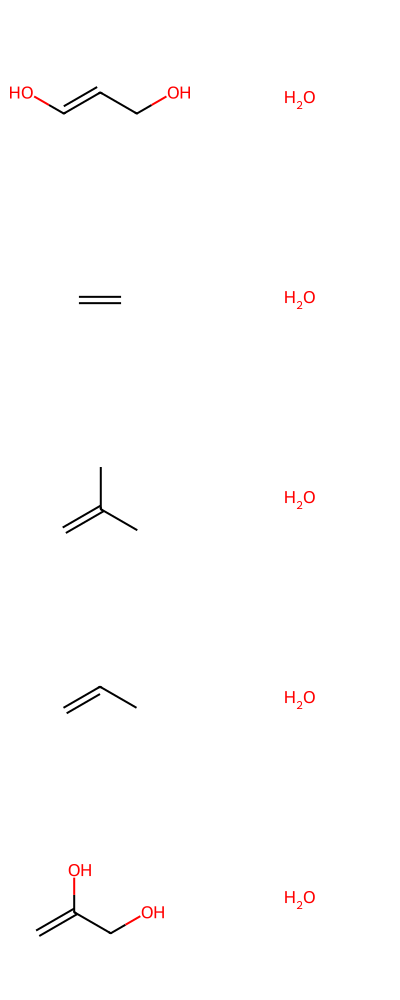

In [21]:
water_elimination_smarts = '[C!H0:1][C:2][O:3]>>[C:1]=[C:2].[O:3]'
water_elimination = AllChem.ReactionFromSmarts(water_elimination_smarts)

# do the reaction on every alcohol in our set
all_products_tuples = [water_elimination.RunReactants((mol, )) for mol in alcohols]
all_products = chain.from_iterable(all_products_tuples)

# convert to smiles and back to keep only unique products
all_products_smiles = [to_smiles(mol_tuple) for mol_tuple in all_products]
all_products_unique = [from_smiles(smiles_tuple) for smiles_tuple in set(all_products_smiles)]
nProductSets = len(all_products_unique)
print("Number of unique product sets:",nProductSets)

# draw each product set on its own line
prod_tpl = tuple(chain(*all_products_unique))
Draw.MolsToGridImage(prod_tpl,molsPerRow=water_elimination.GetNumProductTemplates())

As expected, every reaction produces two compounds, one of which is water.  As before, glycerol gives rise to two _unique_ products.  Phenol does not react because it does not match our reaction rule, which specifies aliphatic carbons.  Unlike the oxidation reaction, $t$-butanol does react, since now it matches the reaction rule, forming isobutylene.  

## A few other examples

### Thiazole synthesis

The case we haven't dealt with yet is defining reactions that take more than one molecule as input.  Here's an example of thiazole synthesis from a thiourea and a ketone.

In [22]:
# Hantzsch thiazole synthesis
thiourea = Chem.MolFromSmiles('CN(C)C(=S)N')
haloketone = Chem.MolFromSmiles('c1ccccc1C(=O)C(C)Cl')
rxn_smarts = '[NH2:1][C:2](=[S:3])[NH0:4].[C:5](=[O:6])[C:7][Cl:8]>>[N:4][c:2]1[s:3][c:5][c:7][n:1]1'
rxn = AllChem.ReactionFromSmarts(rxn_smarts)
product = rxn.RunReactants((thiourea, haloketone))[0][0]
Chem.SanitizeMol(product)

[22:17:24] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 6 8 


rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

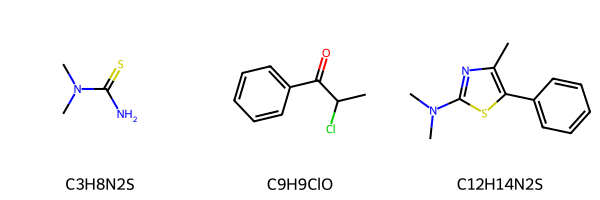

In [23]:
all_three = [thiourea, haloketone, product]
formulae = [rdMolDescriptors.CalcMolFormula(mol) for mol in all_three]
Draw.MolsToGridImage(all_three, legends = formulae)

Two things are worth noting in this case:

1. The reaction as we defined it doesn't track all the atoms; a water and a hydrogen chloride disappear given our reaction definition.

2. The order in which reactants appear in the tuple(s) supplied to `RunReactants()` matters!  In our reaction definition, the thiourea SMARTS came first, so when feeding in reactants the thiourea should appear in the same slot.  If reactants are supplied in the wrong order, they won't match the reaction rule and no products will result (see below).

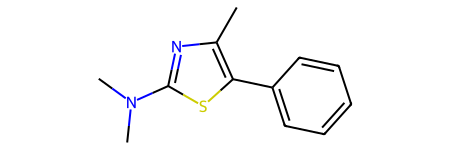

In [27]:
no_products = rxn.RunReactants((thiourea,haloketone ))
no_products[0][0]

### Copper-catalyzed azide/alkyne cycloaddition

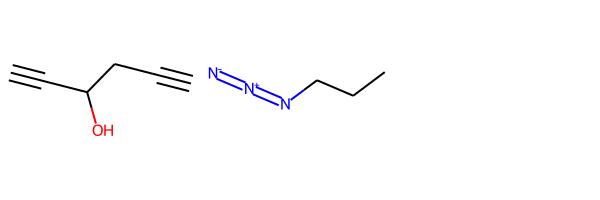

In [24]:
diyne_smiles = 'C#CCC(O)C#C'
azide_smiles = 'CCCN=[N+]=[N-]'

diyne = Chem.MolFromSmiles(diyne_smiles)
azide = Chem.MolFromSmiles(azide_smiles)

Draw.MolsToGridImage([diyne, azide])

In [28]:
# define reaction
copper_click_smarts = '''
[CH:1]#[C:2].[N:3]=[N+:4]=[N-:5]>>
[c:1]1[c:2][n-0:3][n-0:4][n-0:5]1.
[c:2]1[c:1][n-0:3][n-0:4][n-0:5]1
'''

copper_click = AllChem.ReactionFromSmarts(copper_click_smarts)

$\require{mhchem}$
Most varieties of the copper click work on terminal alkynes.  That presents a problem if we want to represent the variable regioselectivity (sometimes 1,4-disubstituted triazoles result, and sometimes 1,5-disubstituted triazoles result), because in the reactions SMARTS each carbon must be labeled with a specified & unique number.  So defining a reactant as something like `'([CH:1]#[C:2],[CH:2]#[C:1])'`, meaning that atom numbering is either $\ce{H-^1C^#^2C-R}$ **or** $\ce{H-^2C^#^1C-R}$) is NOT allowed.

Here, we solve the problem by letting the reaction form two products, the first of which is the 1,4 product and the second of which is the 1,5 product.

In [26]:
products_tuples = copper_click.RunReactants((diyne, azide))
products = list(chain.from_iterable(products_tuples))
[Chem.SanitizeMol(prod) for prod in products]

[rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE]

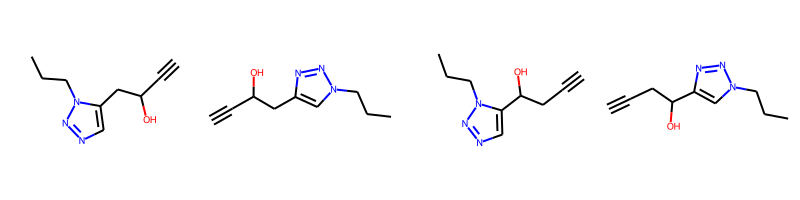

In [27]:
Draw.MolsToGridImage(products, molsPerRow = 4)

The reaction rule, as we saw above with glycerol, is only executed once per species.  So "reactive" groups remain in the output molecules.  Some simple Python scripting could then react these molecules again, generating the (bis)-triazoles.

For more complex editing and manipulation of molecules, it might be worthwhile to investigate [RWMol objects](http://www.rdkit.org/Python_Docs/rdkit.Chem.rdchem.RWMol-class.html) instead of or in addition to the SMARTS reactions examples illustrated here.

tutorial author: Curt Fischer, Jan 2017